In [5]:
from langgraph.graph import StateGraph
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_tavily import TavilySearch
from typing import Annotated, List
from langgraph.graph.message import AnyMessage, add_messages
from typing_extensions import TypedDict

class State(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]

load_dotenv()

llm = init_chat_model("openai:gpt-4.1")

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

tool_node = ToolNode(tools=[tool])

# Define a new graph
workflow = StateGraph(State)

# Add the node to the graph. This node will interrupt when it is invoked.
workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `human_node` so the first node will interrupt
workflow.add_edge("__start__", "chatbot")
workflow.add_conditional_edges(
    "chatbot",
    tools_condition,
)
workflow.add_edge("tools", "chatbot")

# Compile the workflow into an executable graph
graph = workflow.compile()

In [6]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I help you today?
Assistant: 
Assistant: {"query": "최강욱 profile and recent news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "최강욱 - 나무위키", "url": "https://namu.wiki/w/최강욱", "content": "최강욱 변호사는 3군단 근무 등을 통해서 군단장으로 재직하며 각종 논란을 빚은 신일순의 문제점을 파악했고, 결국 군 검사 자격으로 구속했다.", "score": 0.444059, "raw_content": null}, {"title": "'조국 아들 인턴 허위 발언' 최강욱 유죄 확정 - 한국일보", "url": "https://www.hankookilbo.com/News/Read/A2024121209520004061", "content": "최강욱 전 더불어민주당 의원이 10월 31일 김건희 여사의 도이치모터스 주가조작 연루 의혹을 검찰이 불기소 처분한 데 대한 항고장을 접수하기", "score": 0.418341, "raw_content": null}], "response_time": 7.61}
Assistant: 최강욱(Choi Kang-wook)은 대한민국의 변호사이며, 전 더불어민주당 국회의원입니다. 그는 변호사로 활동하며 사회적 이슈에 적극적으로 발언해 온 인물로, 정치인으로도 잘 알려져 있습니다.

최근 주요 이슈로는 '조국 전 장관 아들의 인턴 확인서 허위 작성'과 관련되어 유죄 판결이 확정된 바 있습니다. 또한 검찰의 김건희 여사 주가조작 의혹 불기소 처분에 대해 항고장을 제출하는 등 적극적으로 정치 현안에 목소리를 내고 있습니다.

좀 더 상세한 이력이나 최근 뉴스가 필요하시면 알려주세요.
Assistant: 안녕하세요! 혹시 “ㅂ”이라고만 입력하셨는데, 궁금하신 점이나 도와드릴 내용이 있으실까요? 더 구

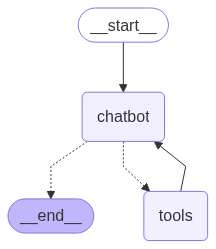

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [13]:
graph = workflow.compile(checkpointer=memory)

In [7]:
config = {"configurable": {"thread_id": "1"}}

In [18]:
user_input = "recall my name"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

recall my name
================================== Ai Message ==================================

Your name is Jake! If you need anything else, just let me know.


In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break